<a href="https://colab.research.google.com/github/JRose31/NLP-WikiAPI/blob/main/NLPWikiAPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Definition

Utilizing a dataset of text and wikipedias API, find celebrities that are similar any specified celebrity utilizing their cooresponding text.

## Collect/Load Data

Here, I'm mounting my drive in order to acess the data from this notebook.

In [68]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


I'll install the basic packages required to begin tackling a problem like this.

In [69]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import re

Now I'll read in the dataset into a DataFrame.

In [70]:
df = pd.read_csv('/drive/My Drive/Cohort_7/Projects/Project 4/Data/Project_4.csv')
df.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


## Initial Exploration

With the dataset being fairly small, I wouldnt anticipate there being much to clean, but I'll still explore the data to know what cleaning it does need. 

How many observations are in the dataset?

In [71]:
df.shape

(42786, 3)

`42,786` observations are in this dataset. Now I'll check for any empty or null values.

In [72]:
df.isnull().sum()

URI     0
name    0
text    0
dtype: int64

It looks as if there aren't any null values in this dataset. What about duplicates?

In [73]:
uniques = []

for idx, name in enumerate(df.name):
  if name not in uniques:
    uniques.append(name)
  else:
    print(idx, name)

17249 author)


There's a duplicate of `'author)'` at index `17249`. I,ll get the index of its twin and visually inspect them.

In [74]:
duplicates = []

for idx, name in enumerate(df.name):
  if 'author)' == name:
    duplicates.append(idx)

df.iloc[duplicates]

,URI,name,text
787,<http://dbpedia.org/resource/James_Grieve_(tra...,author),james grieve born 1934 is an australian transl...
17249,<http://dbpedia.org/resource/Steve_Greenberg_(...,author),steve greenberg december 20 1960 is an america...


The names seem to be stored in the beginning of the text string. I'll deal with this in the next step, Data cleaning,

## Data Cleaning

I'll start off by reassning the names for the duplicates to their respective celebrities.

In [75]:
df['name'].iloc[787], df['name'].iloc[17249] = 'James Grieve (author)', 'Steve Greenberg (author)'

Now I'll deal with some of the messy text.

In [76]:
df['name'].iloc[-2]

'Tatiana Faberg%C3%A9'

With the above serving as an example, I'll use regular expressions to get rid of the `'%C3%A9'` and similar string patterns from the names in the `name` column.

In [77]:
import re

df['name'] = df['name'].str.replace(r'(%\w\w)', '')

In [78]:
df['name'].iloc[-2]

'Tatiana Faberg'

With the data cleaned, I'll process it and fit a NearestNeighbors model with it.

## Data Processing

First I'll import the libraries used to further clean the text and get in processed.

In [79]:
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import NearestNeighbors

I'm using `CountVectorizer` to further clean the data and then performing a TF IDF tranformation on all of the text.

In [80]:
# Clean and vectorize text
vectorizer = CountVectorizer(stop_words='english')
bow_vec = vectorizer.fit_transform(list(df['text']))

# Perform TF IDF transformation
tf_idf_tran = TfidfTransformer()
tf_idf_sent = tf_idf_tran.fit_transform(bow_vec)

Using the TF IDF sparse matrix, I'll fit a NearestNeighbors model.

In [81]:
nn = NearestNeighbors().fit(tf_idf_sent)

For this example, I'm using Jim Carrey. I'll take a look at his word cloud before moving on to find his nearest nieghbors.

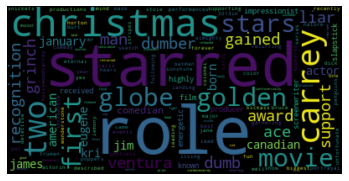

In [82]:
# https://www.datacamp.com/community/tutorials/wordcloud-python
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = df['text'].iloc[42473]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Using actor `Jim Carrey` at index `42473` as a test, I'm passing his index at the sparse matrix to my NearestNeighbors model to see what it predicts as being the 10 closest cleberities based on the test.

In [83]:
# Get nearest neighbors distances
sen = tf_idf_sent[42473,:]
distances, indices = nn.kneighbors(sen, n_neighbors = 10)

df['name'].iloc[indices[0]]

42473       Jim Carrey
28070        Amy Adams
1657      Jeff Daniels
24417    Jesse Ventura
38372      Liam Neeson
19009    James Nesbitt
33224      Ben Affleck
2521     Alfre Woodard
19582     Viveka Davis
11156    Anne Hathaway
Name: name, dtype: object

Recognizing some of these celebrity names, the model is working. However, I'll go further in increasing the accuracy of these predictions by utilzing a full page of wikipedia text as opposed to the short snippets provided in the dataset.

First I'll install Wikipedias API.

In [84]:
#install Wikipedia API
!pip3 install wikipedia-api

Next, I'll create a new DataFrame with the wikipedia text.

In [85]:
import wikipediaapi

# Create DataFrame for wikipedia text of nearest neighbors
full_wiki_df = pd.DataFrame({'Name':list(df['name'].iloc[indices[0]])})

def getWiki(name):
  wikip = wikipediaapi.Wikipedia('en')
  page_ex = wikip.page(name)
  return page_ex.text

# Get wiki text for each celebrity and save in new column 'Text'
full_wiki_df['Text'] = full_wiki_df['Name'].apply(lambda name: getWiki(name))

full_wiki_df

,Name,Text
0,Jim Carrey,"James Eugene Carrey (born January 17, 1962) is..."
1,Amy Adams,"Amy Lou Adams (born August 20, 1974) is an Ame..."
2,Jeff Daniels,"Jeffrey Warren Daniels (born February 19, 1955..."
3,Jesse Ventura,Jesse Ventura (born James George Janos; July 1...
4,Liam Neeson,William John Neeson (born 7 June 1952) is an ...
5,James Nesbitt,William James Nesbitt (born 15 January 1965) ...
6,Ben Affleck,"Benjamin Géza Affleck-Boldt (born August 15, 1..."
7,Alfre Woodard,"Alfre Woodard (; born November 8, 1952) is an ..."
8,Viveka Davis,"Viveka Davis (born August 19, 1969) is an Amer..."
9,Anne Hathaway,"Anne Jacqueline Hathaway (born November 12, 19..."


Now I'll use the nearest neighbors to the actor `Jim Carrey` and see what order my model puts them based on their entire wikipedia text.

In [86]:
vectorizer = CountVectorizer(stop_words='english')
bow_vec = vectorizer.fit_transform(list(full_wiki_df['Text']))

tf_idf_tran = TfidfTransformer()
tf_idf_sent = tf_idf_tran.fit_transform(bow_vec)

nn = NearestNeighbors().fit(tf_idf_sent)

# Get nearest neighbors distances
sen = tf_idf_sent[0,:]
distances, indices = nn.kneighbors(sen, n_neighbors = 10)

full_wiki_df['Name'].iloc[indices[0]]

0       Jim Carrey
2     Jeff Daniels
9    Anne Hathaway
7    Alfre Woodard
1        Amy Adams
4      Liam Neeson
3    Jesse Ventura
5    James Nesbitt
8     Viveka Davis
6      Ben Affleck
Name: Name, dtype: object

Looking at the index column, the orders did change and so the full wikipedia text did have an influence in the prediction this time.

---

Now I'm creating an interface which provides more insight into the celebrities through displaying the results of the sentiment analysis visually..

## Prac-App

Again, first I'll initialize a NearestNeighbors models and fit it with the text current text data to get the first `n` nearest neighbors to the specified celebrity.

In [87]:
init_vectorizer = CountVectorizer(stop_words='english')
init_bow_vec = init_vectorizer.fit_transform(list(df['text']))

init_tf_idf_tran = TfidfTransformer()
init_tf_idf_sent = init_tf_idf_tran.fit_transform(init_bow_vec)

init_nn = NearestNeighbors().fit(init_tf_idf_sent)

Now I'll use the arguments of a celebrity name and `n` nearest neighbors to apply NLP to the wikipedia text to that celebrities `n` nearest neighbors and get an even more accurate order of those `n` celebrities.

In [88]:
from sklearn.preprocessing import MinMaxScaler
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

def nearestCeleb(n, new_name = 'Jim Carrey'):
  print(f'Matching people like {new_name}...')

  # Still get last person in range specified
  n = n+1

  # Get index of specified celebrity
  idx = 0
  for i, v in enumerate(df['name']):
    if v == new_name:
      idx = idx+i

  # Get n nearest neighbors
  sen = init_tf_idf_sent[idx,:]
  distances, indices = init_nn.kneighbors(sen, n_neighbors = n)

  # Create DataFrame with wikipedia text
  wiki_df = pd.DataFrame({'Matches':list(df['name'].iloc[indices[0]])})
  wiki_df['Text'] = wiki_df['Matches'].apply(lambda name: getWiki(name))

  # Clean wikipedia text
  vectorizer = CountVectorizer(stop_words='english')
  bow_vec = vectorizer.fit_transform(list(wiki_df['Text']))

  # Perform TF IDF tranfromation
  tf_idf_tran = TfidfTransformer()
  tf_idf_sent = tf_idf_tran.fit_transform(bow_vec)

  # Fit sparse matrix into NearestNeighbors model
  nn = NearestNeighbors().fit(tf_idf_sent)

  # Get nearest neighbors indices
  sen = tf_idf_sent[0,:]
  distances, indices = nn.kneighbors(sen, n_neighbors = n)
  print('Match complete.')

  # Perfrom sentiment analysis on all text of nearest neighbors
  wiki_df['Text'] = wiki_df['Text'].apply(lambda x: list(TextBlob(x).sentiment))

  # Scale polarity and subjectivity scores for plotting
  scaler = MinMaxScaler()
  wiki_df['Text'].apply(lambda x: scaler.fit([x]))
  wiki_df['Text'].apply(lambda x: scaler.transform([x]))

  # Output nearest neighbors and their sentiment analysis
  for i in range(n-1):
    test = wiki_df['Text'].iloc[i]
    name = wiki_df['Matches'].iloc[i]

    test

    fig, ax = plt.subplots(figsize=(4, .6))
    ax.barh('Polarity', test[0], height=0.7, align='center')
    ax.barh('Subjectivity', test[1], height=0.7, align='center')
    ax.set_xlim([0, 1])
    ax.set_title(name);

interact(nearestCeleb, n=widgets.IntSlider(min=1,max=20,step=1,value=10));


interactive(children=(IntSlider(value=10, description='n', max=20, min=1), Text(value='Jim Carrey', descriptio…

## References

* https://www.datacamp.com/community/tutorials/wordcloud-python
* https://docs.python.org/3/library/re.html
* https://www.mediawiki.org/wiki/API:Main_page